Import all necessary libraries and functions, as well as the primary data-structure

In [2]:
# This builds the full data-structure, including
# 1. initial parameter and covariate sets
# 2. pre-processing settings and additional parameters-induced changes to data

%run fMRI_prestats_data-struct.ipynb

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


subject(s) missing!
First line of list-alignment:   FED006 FED006 FED007
Control relevant files!


 The following subjects where excluded from further analysis due to false file numbers or missing data:  
 EPI:  ['FED006'] T1:  ['FED006']
The new subject list after initial data and image file checkup:

['FED007', 'FED008', 'FED009', 'FED010', 'FED011', 'FED012', 'FED013', 'FED014', 'FED015', 'FED016', 'FED017', 'FED018', 'FED019', 'FED020', 'FED021', 'FED022', 'FED023', 'FED024', 'FED025', 'FED026', 'FED027', 'FED028', 'FED029', 'FED030', 'FED031', 'FED032', 'FED033', 'FED034', 'FED035', 'FED036', 'FED037', 'FED038', 'FED039', 'FED040', 'FED041', 'FED042', 'FED043', 'FED044', 'FED045', 'FED046', 'FED047', 'FED048', 'FED049', 'FED050', 'FED051', 'FED052', 'FED053', 'FED054', 'FED055', 'FED056', 'FED057', 'FED058', 'FED059', 'FED060', 'FED061', 'FED062', 'FED063', 'FED064', 'FED065', 'FED066', 'FED067', 'FED068']


That leaves a total of  62 remaining subjects.


The following parameters

In [3]:
# Delete all variables in the current namespace from globals except those defined at the initiation of the data structure
for var in dir():
    if (var != 'data_varspace_init' and var not in data_varspace_init):
        #print(var, " will be deleted from this notebook's global namespace")
        del globals()[var]

In [1]:
# control results
#key = random.sample(data.keys(), 1)
#print(data[key[0]])
#print(data["general"])

 Pre-configurations

In [5]:
# (Re-)activate nipype's INFO output for interfaces and workflows , as we want to see what's going on
logging.getLogger('nipype.interface').setLevel("INFO")
logging.getLogger('nipype.workflow').setLevel("INFO")

In [6]:
# set default data ouput for all FSL operations
fsl.FSLCommand.set_default_output_type('NIFTI_GZ')

In [7]:
# define additional files
spm_mnitpm = f"{tpmdir}TPM.nii"

# 1st-level modelling

In [37]:
# define input files
structs = sorted([i for sub in FEDs
                  for i in data[sub]["files"]
                  if re.match(r'.*fMRI.*(T1_MPR).*.nii.gz$', i)])  # exclude VBM files

prepped_funcs = sorted([i for sub in FEDs
                        for i in data[sub]["files"]
                        if re.match(r'.*(FMRI).*(?<=-s9-m).nii.gz$', i)])

# control presence and accuracy of raw structurals and preprocessed files
print("\nnumber of raw structurals in native space:\n", len(structs))
print("\nnumber of preprocessed files:\n", len(prepped_funcs))
print("\nnumber of subject directories:\n", len(FED_dirs))


number of raw structurals in native space:
 61

number of preprocessed files:
 0

number of subject directories:
 61


In [39]:
%%script env STRUCTS="$structs" bash
# transfer structurals to bash array and get rid of pythonean list/string characters
STRUCTS_arr=($(echo $STRUCTS | sed -e 's/[][]//g' -e 's/,//g' -e "s/'//g"))

# gzip each structural file
for file in "${STRUCTS_arr[@]}"; do
gunzip $file
done

In [15]:
%%script env FUNCS="$prepped_funcs" bash
# transfer functionals to bash array and get rid of pythonean list/string characters
FUNCS_arr=($(echo $FUNCS | sed -e 's/[][]//g' -e 's/,//g' -e "s/'//g"))

# gzip each functional file
for file in "${FUNCS_arr[@]}"; do
gunzip $file
done

In [40]:
# update files for all subs
update_files(collect_files())

In [41]:
# collect the unzipped structurals and functionals for processing with SPM
structs = sorted([i for sub in FEDs
                  for i in data[sub]["files"]
                  if re.match(r'.*T1_MPRAGE.nii$', i)])

prepped_funcs = sorted([i for sub in FEDs
                        for i in data[sub]["files"]
                        if re.match(r'.*(FMRI).*(?<=-s9-m).nii$', i)])

# control presence and accuracy of raw structurals and preprocessed files
print("\nnumber of raw structurals in native space:\n", len(structs))
print("\nnumber of preprocessed files:\n", len(prepped_funcs))
print("\nnumber of subject directories:\n", len(FED_dirs))


number of raw structurals in native space:
 61

number of preprocessed files:
 61

number of subject directories:
 61


Specify the model parameters for the SPM model

In [18]:
# specify the design information and the model
for func, sub, subdir in zip(prepped_funcs, FEDs, FED_dirs):
    print(func, sub, subdir)  # for some reason, the print throws errors if you don't help it focus^^
    # define artdetect directory
    art_dir = f"{subdir}artdetect/"
    modelspec = pe.Node(model.SpecifySPMModel(), name="model_specifications")
    modelspec.inputs.input_units = 'secs'
    modelspec.inputs.output_units = 'secs'
    modelspec.inputs.functional_runs = func
    modelspec.inputs.time_repetition = data[sub]["parameters"]["EPI_RT"]
    modelspec.inputs.high_pass_filter_cutoff = 128  # SPM default -> makes about 71 volumes at TR = 1.8
    modelspec.inputs.subject_info = data[sub]["parameters"]["trialinfo"]
    modelspec.inputs.realignment_parameters = f"{subdir}FMRI_mc.nii.gz.par"  # first run with, but see if removing them might be better later
    modelspec.inputs.outlier_files = f"{art_dir}art.FMRI_mc_outliers.txt"
    modelspec.inputs.parameter_source = "FSL"
    modelspec.base_dir = subdir
    # run it
    res = modelspec.run()

/fMRI/FED007/FMRI_mc-bet-cr-s9-m.nii FED007 /fMRI/FED007/
210428-07:47:30,256 nipype.workflow INFO:
	 [Node] Setting-up "model_specifications" in "/fMRI/FED007/model_specifications".
210428-07:47:30,264 nipype.workflow INFO:
	 [Node] Running "model_specifications" ("nipype.algorithms.modelgen.SpecifySPMModel")
210428-07:47:30,301 nipype.workflow INFO:
	 [Node] Finished "model_specifications".
/fMRI/FED008/FMRI_mc-bet-cr-s9-m.nii FED008 /fMRI/FED008/
210428-07:47:30,304 nipype.workflow INFO:
	 [Node] Setting-up "model_specifications" in "/fMRI/FED008/model_specifications".
210428-07:47:30,311 nipype.workflow INFO:
	 [Node] Running "model_specifications" ("nipype.algorithms.modelgen.SpecifySPMModel")
210428-07:47:30,349 nipype.workflow INFO:
	 [Node] Finished "model_specifications".
/fMRI/FED009/FMRI_mc-bet-cr-s9-m.nii FED009 /fMRI/FED009/
210428-07:47:30,351 nipype.workflow INFO:
	 [Node] Setting-up "model_specifications" in "/fMRI/FED009/model_specifications".
210428-07:47:30,357 nipyp

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/fMRI/FED007/model_specifications/art.FMRI_mc_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


210428-07:47:30,488 nipype.workflow INFO:
	 [Node] Finished "model_specifications".
/fMRI/FED012/FMRI_mc-bet-cr-s9-m.nii FED012 /fMRI/FED012/
210428-07:47:30,490 nipype.workflow INFO:
	 [Node] Setting-up "model_specifications" in "/fMRI/FED012/model_specifications".
210428-07:47:30,497 nipype.workflow INFO:
	 [Node] Running "model_specifications" ("nipype.algorithms.modelgen.SpecifySPMModel")
210428-07:47:30,532 nipype.workflow INFO:
	 [Node] Finished "model_specifications".
/fMRI/FED013/FMRI_mc-bet-cr-s9-m.nii FED013 /fMRI/FED013/
210428-07:47:30,534 nipype.workflow INFO:
	 [Node] Setting-up "model_specifications" in "/fMRI/FED013/model_specifications".
210428-07:47:30,539 nipype.workflow INFO:
	 [Node] Running "model_specifications" ("nipype.algorithms.modelgen.SpecifySPMModel")
210428-07:47:30,576 nipype.workflow INFO:
	 [Node] Finished "model_specifications".
/fMRI/FED014/FMRI_mc-bet-cr-s9-m.nii FED014 /fMRI/FED014/
210428-07:47:30,578 nipype.workflow INFO:
	 [Node] Setting-up "mod

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/fMRI/FED025/model_specifications/art.FMRI_mc_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/fMRI/FED028/model_specifications/art.FMRI_mc_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


210428-07:47:31,369 nipype.workflow INFO:
	 [Node] Finished "model_specifications".
/fMRI/FED031/FMRI_mc-bet-cr-s9-m.nii FED031 /fMRI/FED031/
210428-07:47:31,372 nipype.workflow INFO:
	 [Node] Setting-up "model_specifications" in "/fMRI/FED031/model_specifications".
210428-07:47:31,380 nipype.workflow INFO:
	 [Node] Running "model_specifications" ("nipype.algorithms.modelgen.SpecifySPMModel")
210428-07:47:31,420 nipype.workflow INFO:
	 [Node] Finished "model_specifications".
/fMRI/FED032/FMRI_mc-bet-cr-s9-m.nii FED032 /fMRI/FED032/
210428-07:47:31,423 nipype.workflow INFO:
	 [Node] Setting-up "model_specifications" in "/fMRI/FED032/model_specifications".
210428-07:47:31,430 nipype.workflow INFO:
	 [Node] Running "model_specifications" ("nipype.algorithms.modelgen.SpecifySPMModel")
210428-07:47:31,478 nipype.workflow INFO:
	 [Node] Finished "model_specifications".
/fMRI/FED033/FMRI_mc-bet-cr-s9-m.nii FED033 /fMRI/FED033/
210428-07:47:31,482 nipype.workflow INFO:
	 [Node] Setting-up "mod

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/fMRI/FED039/model_specifications/art.FMRI_mc_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


210428-07:47:32,2 nipype.workflow INFO:
	 [Node] Finished "model_specifications".
/fMRI/FED043/FMRI_mc-bet-cr-s9-m.nii FED043 /fMRI/FED043/
210428-07:47:32,4 nipype.workflow INFO:
	 [Node] Setting-up "model_specifications" in "/fMRI/FED043/model_specifications".
210428-07:47:32,12 nipype.workflow INFO:
	 [Node] Running "model_specifications" ("nipype.algorithms.modelgen.SpecifySPMModel")
210428-07:47:32,49 nipype.workflow INFO:
	 [Node] Finished "model_specifications".
/fMRI/FED044/FMRI_mc-bet-cr-s9-m.nii FED044 /fMRI/FED044/
210428-07:47:32,51 nipype.workflow INFO:
	 [Node] Setting-up "model_specifications" in "/fMRI/FED044/model_specifications".
210428-07:47:32,57 nipype.workflow INFO:
	 [Node] Running "model_specifications" ("nipype.algorithms.modelgen.SpecifySPMModel")
210428-07:47:32,98 nipype.workflow INFO:
	 [Node] Finished "model_specifications".
/fMRI/FED045/FMRI_mc-bet-cr-s9-m.nii FED045 /fMRI/FED045/
210428-07:47:32,100 nipype.workflow INFO:
	 [Node] Setting-up "model_specif

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/fMRI/FED047/model_specifications/art.FMRI_mc_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


210428-07:47:32,420 nipype.workflow INFO:
	 [Node] Finished "model_specifications".
/fMRI/FED053/FMRI_mc-bet-cr-s9-m.nii FED053 /fMRI/FED053/
210428-07:47:32,422 nipype.workflow INFO:
	 [Node] Setting-up "model_specifications" in "/fMRI/FED053/model_specifications".
210428-07:47:32,430 nipype.workflow INFO:
	 [Node] Running "model_specifications" ("nipype.algorithms.modelgen.SpecifySPMModel")
210428-07:47:32,470 nipype.workflow INFO:
	 [Node] Finished "model_specifications".
/fMRI/FED054/FMRI_mc-bet-cr-s9-m.nii FED054 /fMRI/FED054/
210428-07:47:32,472 nipype.workflow INFO:
	 [Node] Setting-up "model_specifications" in "/fMRI/FED054/model_specifications".
210428-07:47:32,482 nipype.workflow INFO:
	 [Node] Running "model_specifications" ("nipype.algorithms.modelgen.SpecifySPMModel")
210428-07:47:32,533 nipype.workflow INFO:
	 [Node] Finished "model_specifications".
/fMRI/FED055/FMRI_mc-bet-cr-s9-m.nii FED055 /fMRI/FED055/
210428-07:47:32,536 nipype.workflow INFO:
	 [Node] Setting-up "mod

Create the design .mat file

In [19]:
# use the design specifications to create an SPM 1st level design .mat file
for sub, subdir in zip(FEDs, FED_dirs):
    # define model directory
    model_dir = f"{subdir}model_specifications/"
    modelinfo = loadpkl(f"{model_dir}result_model_specifications.pklz")
    #print(modelinfo.outputs.session_info)
    # create SPM level1design
    level1design = pe.Node(spm.Level1Design(), name = "level1design")
    level1design.inputs.interscan_interval = data[sub]["parameters"]["EPI_RT"]
    level1design.inputs.bases = {'hrf': {'derivs': [1, 0]}}
    level1design.inputs.timing_units = 'secs'
    level1design.inputs.session_info = modelinfo.outputs.session_info
    level1design.inputs.global_intensity_normalization = 'scaling'  # consider https://www.ernohermans.com/wp-content/uploads/2016/09/spm12_startersguide.pdf for a thorough think ..
    level1design.inputs.model_serial_correlations = 'AR(1)'
    #level1design.inputs.spm_mat_dir = model_dir
    level1design.base_dir = model_dir
    #   levlevel1design.inputs.volterra_expansion_order = 2
    # look at https://www.fil.ion.ucl.ac.uk/spm/course/slides02/overview/Connect.html on how the above may model effective connectivity
    # run it
    res = level1design.run()
    # print it
    print(res.outputs)

210428-07:48:08,81 nipype.workflow INFO:
	 [Node] Setting-up "level1design" in "/fMRI/FED007/model_specifications/level1design".
210428-07:48:08,140 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
210428-07:48:16,212 nipype.workflow INFO:
	 [Node] Finished "level1design".

spm_mat_file = /fMRI/FED007/model_specifications/level1design/SPM.mat

210428-07:48:16,217 nipype.workflow INFO:
	 [Node] Setting-up "level1design" in "/fMRI/FED008/model_specifications/level1design".
210428-07:48:16,296 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
210428-07:48:26,208 nipype.workflow INFO:
	 [Node] Finished "level1design".

spm_mat_file = /fMRI/FED008/model_specifications/level1design/SPM.mat

210428-07:48:26,221 nipype.workflow INFO:
	 [Node] Setting-up "level1design" in "/fMRI/FED009/model_specifications/level1design".
210428-07:48:26,308 nipype.workflow INFO:
	 [Node] Running "level1design" ("n

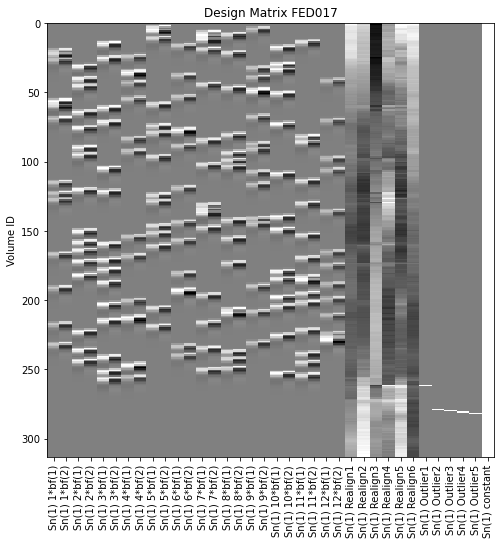

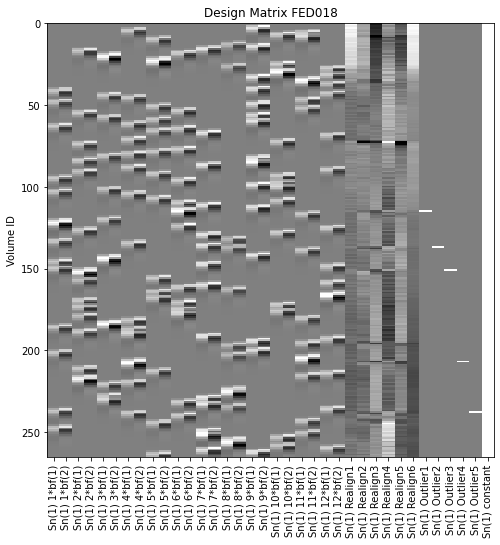

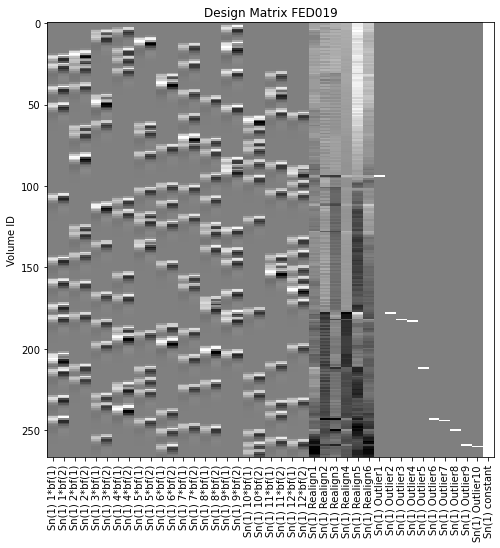

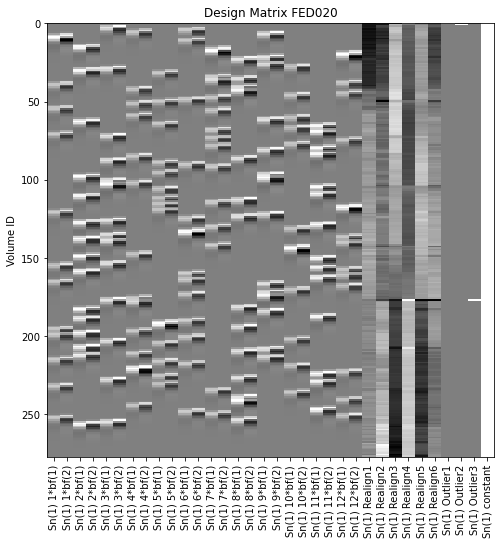

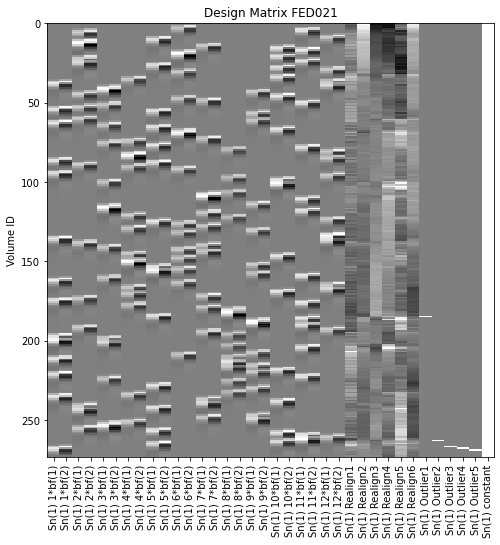

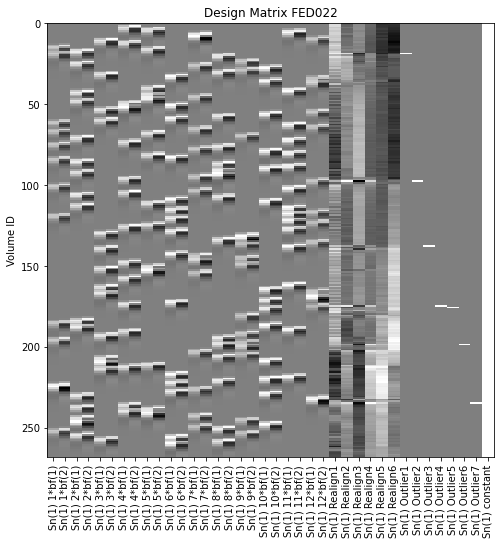

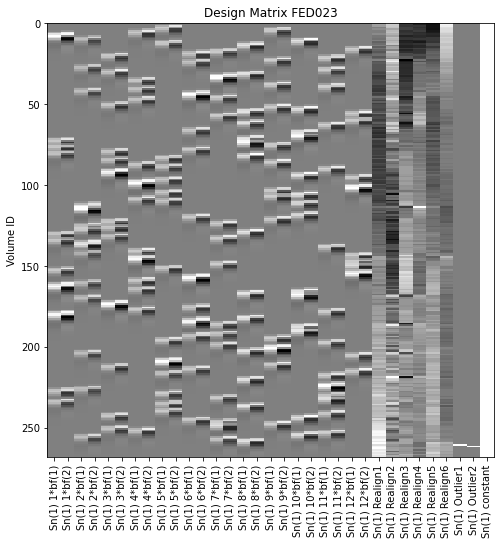

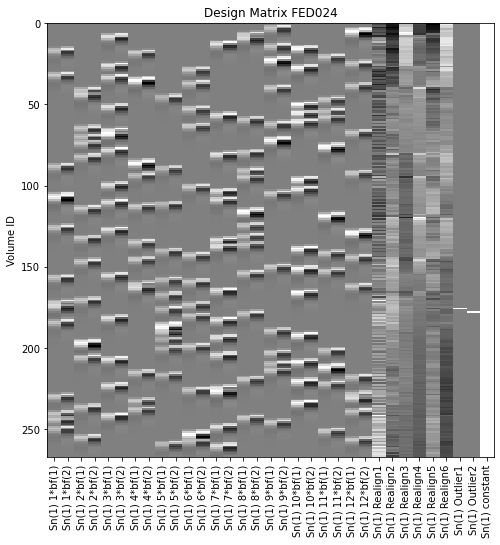

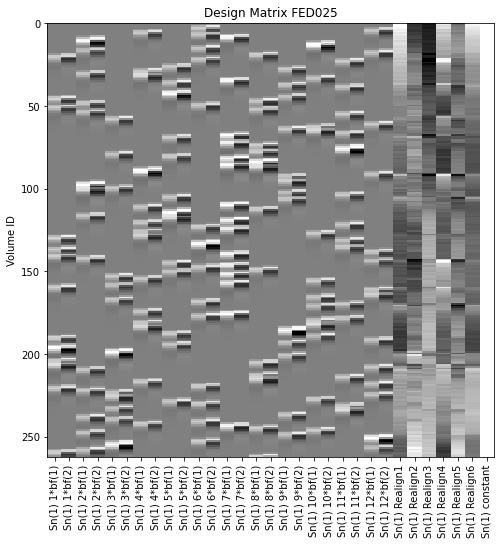

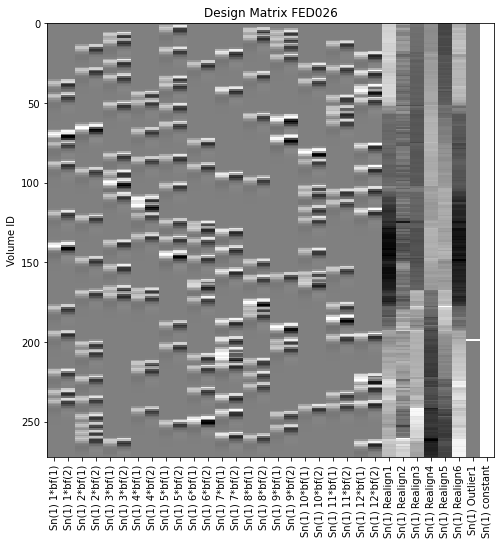

In [21]:
# print a few example design matrices to make sure everything looks alright
# Access SPM.mat via loadmat function
for subdir in FED_dirs[10:20]:
    spmmat = sp.io.loadmat(f"{subdir}model_specifications/level1design/SPM.mat",
                       struct_as_record=False)
    # Design matrix and the names of the regressors are hidden in the spmmat variable, but they can be accessed as follows
    designMatrix = spmmat['SPM'][0][0].xX[0][0].X
    names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]
    # Normalize the design matrix, so that each column has a maximum amplitude of 1.
    # This is just for visualization purposes, otherwise rotation parameters with their rather small values will not show up.
    normed_design = designMatrix / np.abs(designMatrix).max(axis=0)
    # Plot the design matrix.
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.imshow(normed_design, aspect='auto', cmap='gray', interpolation='none')
    plt.title(f"Design Matrix {subdir.rsplit('/', 2)[1]}")
    ax.set_ylabel('Volume ID')
    ax.set_xticks(np.arange(len(names)))
    ax.set_xticklabels(names, rotation=90);  # semicolon suppresses unwanted text-output from "set*" commands

Estimate the 1st level SPM model

In [22]:
# estimate the 1st level design using restricted Maximum Likelihood (the "Classical" approach ^^)
# define input files
spmmats = sorted([os.path.join(f"{sub}model_specifications/level1design/", i)
                  for sub in FED_dirs
                  for i in os.listdir(f"{sub}model_specifications/level1design/")
                  if re.match(r'.*SPM.mat$', i)])

for mat in spmmats:
    level1estimate = pe.Node(spm.EstimateModel(), name = "mod_estimate")
    level1estimate.inputs.estimation_method = {'Classical': 1}
    level1estimate.inputs.spm_mat_file = mat
    level1estimate.base_dir = mat.rsplit('/', 1)[0]
    # run it
    res = level1estimate.run()
    # print it
    print(res.outputs)

210428-08:00:17,543 nipype.workflow INFO:
	 [Node] Setting-up "mod_estimate" in "/fMRI/FED007/model_specifications/level1design/mod_estimate".
210428-08:00:17,551 nipype.workflow INFO:
	 [Node] Running "mod_estimate" ("nipype.interfaces.spm.model.EstimateModel")
210428-08:00:32,167 nipype.workflow INFO:
	 [Node] Finished "mod_estimate".

ARcoef = <undefined>
Cbetas = <undefined>
RPVimage = /fMRI/FED007/model_specifications/level1design/mod_estimate/RPV.nii
SDbetas = <undefined>
SDerror = <undefined>
beta_images = ['/fMRI/FED007/model_specifications/level1design/mod_estimate/beta_0001.nii', '/fMRI/FED007/model_specifications/level1design/mod_estimate/beta_0002.nii', '/fMRI/FED007/model_specifications/level1design/mod_estimate/beta_0003.nii', '/fMRI/FED007/model_specifications/level1design/mod_estimate/beta_0004.nii', '/fMRI/FED007/model_specifications/level1design/mod_estimate/beta_0005.nii', '/fMRI/FED007/model_specifications/level1design/mod_estimate/beta_0006.nii', '/fMRI/FED007/mode

Write and estimate the 1st level contrasts

In [1]:
# generate GLM contrasts
# (condition: numbers):
# L-I-Neg: 1 L-I-Pos: 2 L-I-Neu: 3   R-I-Neg: 4 R-I-Pos: 5 R-I-Neu: 6
# L-V-Neg: 7 L-V-Pos: 8 L-V-Neu: 9   R-V-Neg: 10 R-V-Pos: 11 R-V-Neu: 12

# based on Koster et al. 2005:
# ENHANCED CUE VALIDITY:
# MDD: 1,4 - 7,10 (p<0.05); 2,5 - 8,11 (n.s.); 3,6 - 9,12 (n.s.)
# Control: 1,4 - 7,10 (p<0.05); 2,5 - 8,11 (p<0.05); 3,6 - 9,12 (n.s.)
# DIFFICULTY IN ATTENTIONAL DISENGAGEMENT:
# MDD: 1,4 - 3,6 (p<0.05); 2,5 - 3,6 (n.s.)
# Control: 1,4 - 3,6 (n.s.); 2,5 - 3,6 (n.s.)
# ATTENTIONAL DISENGAGEMENT:
# no distinguishing feature in previous publications -> None
# No reason to assume direction of effect a priori: Test T contrasts with one F contrast for each behavioural variable

# Original T contrasts
CV_neg = ["NegI-NegV", "T", ["1", "4", "7", "10"], [1, 1, -1, -1]]  # set weights of contrasts to 1 - no cross-run averaging involved here^^
CV_pos = ["PosI-PosV", "T", ["2", "5", "8", "11"], [1, 1, -1, -1]]
CV_neu = ["NeuI-NeuV", "T", ["3", "6", "9", "12"], [1, 1, -1, -1]]
DAD_neg = ["NegI-NeuI", "T", ["1", "4", "3", "6"], [1, 1, -1, -1]]
DAD_pos = ["PosI-NeuI", "T", ["2", "5", "3", "6"], [1, 1, -1, -1]]

# build dictionary for SPM adaptations
contrast_dict = {"CV_neg": CV_neg, "CV_pos": CV_pos, "CV_neu": CV_neu, "DAD_neg": DAD_neg, "DAD_pos": DAD_pos}
# add the F contrasts here
contrast_dict.update({"cvF": ["Cue Validity", "F", [contrast_dict["CV_neg"], contrast_dict["CV_pos"], contrast_dict["CV_neu"]]],
                      "DAD_F": ["Difficulty Attentional Disengagement", "F", [contrast_dict["DAD_neg"], contrast_dict["DAD_pos"]]]})

# # Adapt contrasts to SPM design matrix (temp.deriv. etc.^^) -> UNNECESSARY: Told SPM the derivative model during SPM.mat file building^^
#                                                                             Won't use derivatives for contrasts until explicitly told to do so^^
# for con in contrast_dict.keys():
#     # select only T contrasts
#     if not re.match(r'.*F$', con):
#         # make new list for column selection in each contrast
#         news = []
#         # select list for regressor selection from the design matrix
#         for num in contrast_dict[con][2]:
#             # replace the item appropriately
#             news.append(f"{num}*bf(1)")
#         # replace the contrast with the new values
#         contrast_dict[con][2] = news

# print adapted contrasts
# for con in contrast_dict.keys():
#     print(con, contrast_dict[con])

# put all together for 1st level designs
contrasts_fin = [contrast_dict[con] for con in contrast_dict.keys()]

# print final list
print(contrasts_fin)

[['NegI-NegV', 'T', ['1', '4', '7', '10'], [1, 1, -1, -1]], ['PosI-PosV', 'T', ['2', '5', '8', '11'], [1, 1, -1, -1]], ['NeuI-NeuV', 'T', ['3', '6', '9', '12'], [1, 1, -1, -1]], ['NegI-NeuI', 'T', ['1', '4', '3', '6'], [1, 1, -1, -1]], ['PosI-NeuI', 'T', ['2', '5', '3', '6'], [1, 1, -1, -1]], ['Cue Validity', 'F', [['NegI-NegV', 'T', ['1', '4', '7', '10'], [1, 1, -1, -1]], ['PosI-PosV', 'T', ['2', '5', '8', '11'], [1, 1, -1, -1]], ['NeuI-NeuV', 'T', ['3', '6', '9', '12'], [1, 1, -1, -1]]]], ['Difficulty Attentional Disengagement', 'F', [['NegI-NeuI', 'T', ['1', '4', '3', '6'], [1, 1, -1, -1]], ['PosI-NeuI', 'T', ['2', '5', '3', '6'], [1, 1, -1, -1]]]]]


In [40]:
# generate SPM-type contrast estimates (will take these to 2nd level later on)
for subdir in FED_dirs:
    # create model dirs
    SPMmod_dir = f"{subdir}model_specifications/level1design/mod_estimate/"
    # gather parameter estimates
    beta_ests = sorted([f"{SPMmod_dir}{beta_file}"
                       for beta_file in os.listdir(f"{SPMmod_dir}")
                       if re.match(r'.*beta_[0-9]{4}.nii$', beta_file)])
    # estimate contrasts
    conestimate = pe.Node(spm.EstimateContrast(), name = "1stlevel_contrast_estimates")
    conestimate.inputs.spm_mat_file = f"{SPMmod_dir}SPM.mat"
    conestimate.inputs.beta_images = beta_ests
    conestimate.inputs.residual_image = f"{SPMmod_dir}ResMS.nii"
    conestimate.inputs.contrasts = contrasts_fin
    conestimate.base_dir = SPMmod_dir
    # run it
    res = conestimate.run()
    # print it
    print(res.outputs)

210428-11:17:17,536 nipype.workflow INFO:
	 [Node] Setting-up "1stlevel_contrast_estimates" in "/fMRI/FED007/model_specifications/level1design/mod_estimate/1stlevel_contrast_estimates".
210428-11:17:17,542 nipype.workflow INFO:
	 [Node] Cached "1stlevel_contrast_estimates" - collecting precomputed outputs
210428-11:17:17,543 nipype.workflow INFO:
	 [Node] "1stlevel_contrast_estimates" found cached.

con_images = ['/fMRI/FED007/model_specifications/level1design/mod_estimate/1stlevel_contrast_estimates/con_0001.nii', '/fMRI/FED007/model_specifications/level1design/mod_estimate/1stlevel_contrast_estimates/con_0002.nii', '/fMRI/FED007/model_specifications/level1design/mod_estimate/1stlevel_contrast_estimates/con_0003.nii', '/fMRI/FED007/model_specifications/level1design/mod_estimate/1stlevel_contrast_estimates/con_0004.nii', '/fMRI/FED007/model_specifications/level1design/mod_estimate/1stlevel_contrast_estimates/con_0005.nii', '/fMRI/FED007/model_specifications/level1design/mod_estimate/1s

Normalise the estimated contrast images to MNI space for group level analysis

In [51]:
# In this case SPM12's Normalize routine and normalize to the SPM12 tissue probability map TPM.nii.
# Specify the voxel resolution of the output volumes. If you don't specify it, it will normalize to a voxel resolution of 2x2x2mm.
for struct, subdir in zip(structs, FED_dirs):
    # create model dirs
    SPMcon_dir = f"{subdir}model_specifications/level1design/mod_estimate/1stlevel_contrast_estimates/"
    # gather parameter estimates
    con_ests = sorted([f"{SPMcon_dir}{con_file}"
                       for con_file in os.listdir(f"{SPMcon_dir}")
                       if re.match(r'.*(con|ess)_[0-9]{4}.nii$', con_file)])
    # normalise contrasts
    normalize = pe.Node(spm.Normalize12(), name = "normalize")
    normalize.inputs.jobtype = 'estwrite'
    normalize.inputs.tpm = spm_mnitpm
#    normalize.inputs.write_voxel_sizes = [3, 3, 3]  # original voxelsize, voxelsize-based partial of smoothing - more intuitive to me.
#    will use atlas/template resolution here -> no problems with masks down the line^^
    normalize.inputs.image_to_align = struct
    normalize.inputs.apply_to_files = con_ests
    normalize.base_dir = SPMcon_dir
    # run it
    res = normalize.run()
    # print it
    print(res.outputs)

210429-11:25:06,254 nipype.workflow INFO:
	 [Node] Setting-up "normalize" in "/fMRI/FED007/model_specifications/level1design/mod_estimate/1stlevel_contrast_estimates/normalize".
210429-11:25:06,300 nipype.workflow INFO:
	 [Node] Running "normalize" ("nipype.interfaces.spm.preprocess.Normalize12")
210429-11:28:37,858 nipype.workflow INFO:
	 [Node] Finished "normalize".

deformation_field = /fMRI/FED007/model_specifications/level1design/mod_estimate/1stlevel_contrast_estimates/normalize/y_T1_MPRAGE.nii
normalized_files = ['/fMRI/FED007/model_specifications/level1design/mod_estimate/1stlevel_contrast_estimates/normalize/wcon_0001.nii', '/fMRI/FED007/model_specifications/level1design/mod_estimate/1stlevel_contrast_estimates/normalize/wcon_0002.nii', '/fMRI/FED007/model_specifications/level1design/mod_estimate/1stlevel_contrast_estimates/normalize/wcon_0003.nii', '/fMRI/FED007/model_specifications/level1design/mod_estimate/1stlevel_contrast_estimates/normalize/wcon_0004.nii', '/fMRI/FED007/

Check success of normalisation before 2nd level analysis

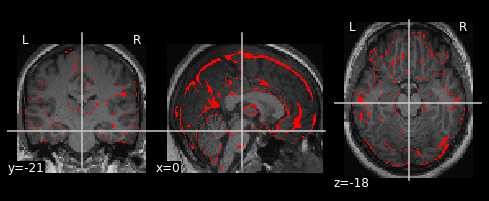

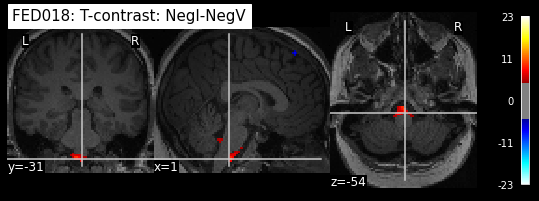

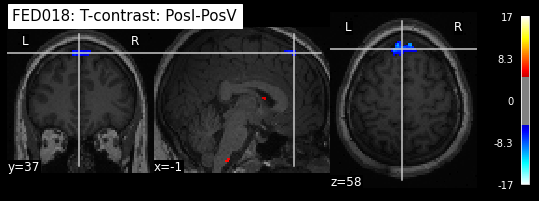

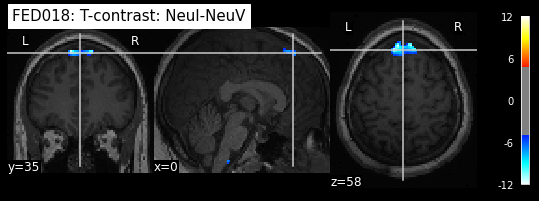

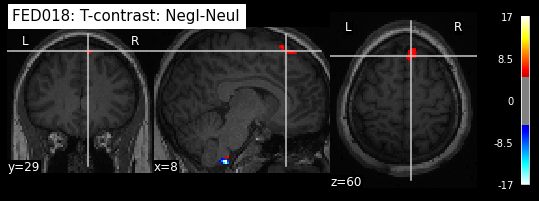

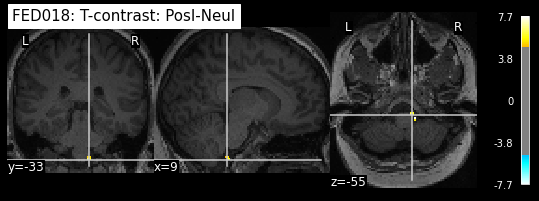

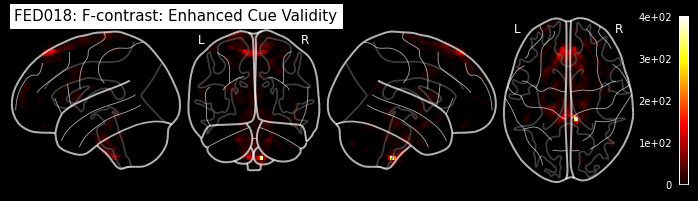

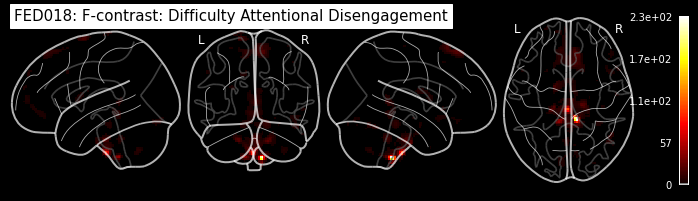

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  "Non-finite values detected. "


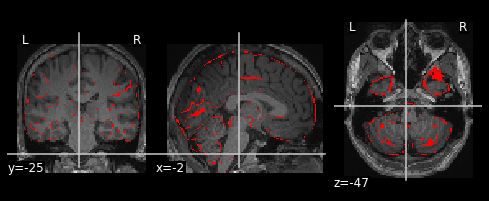

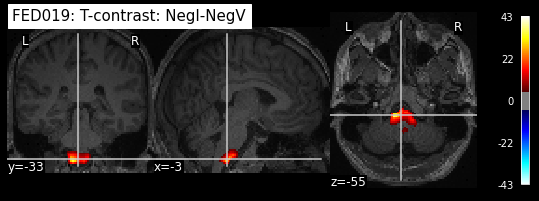

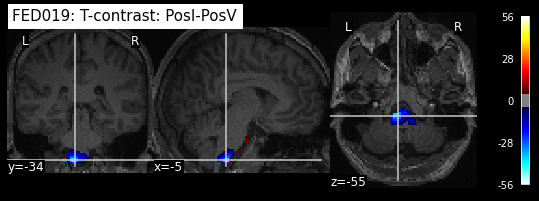

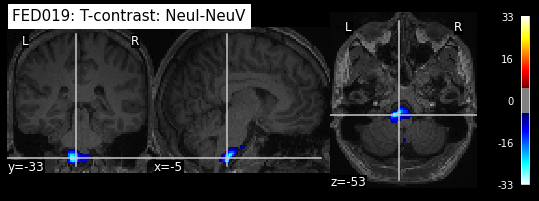

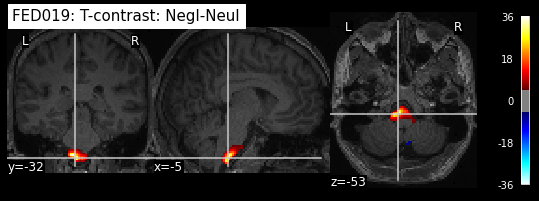

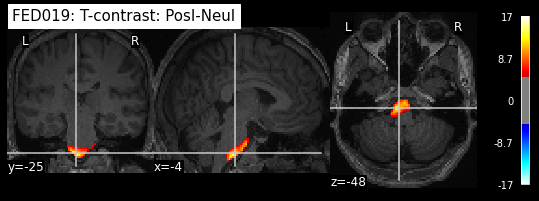

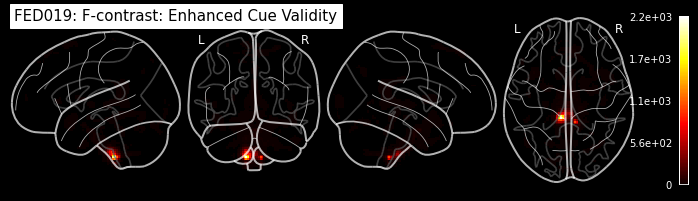

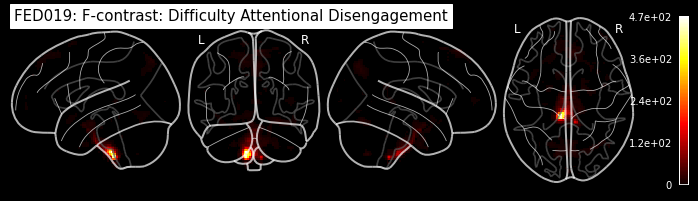

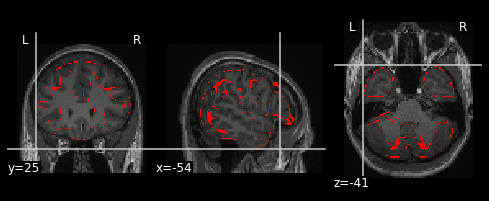

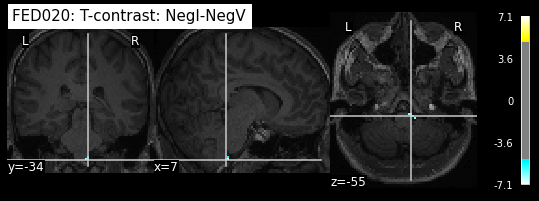

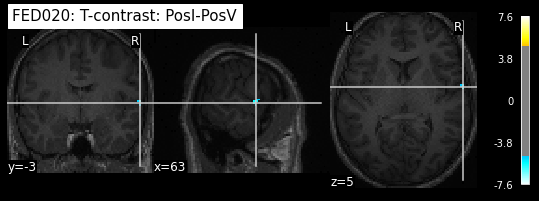

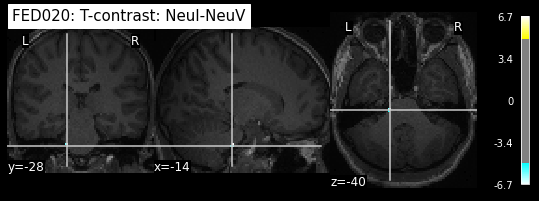

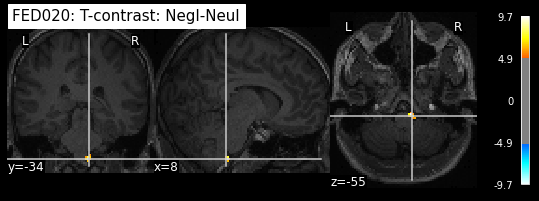

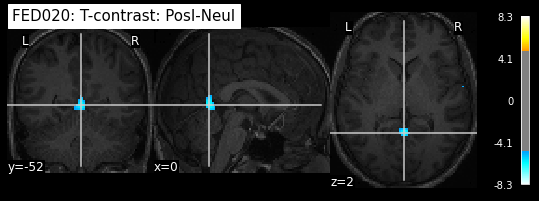

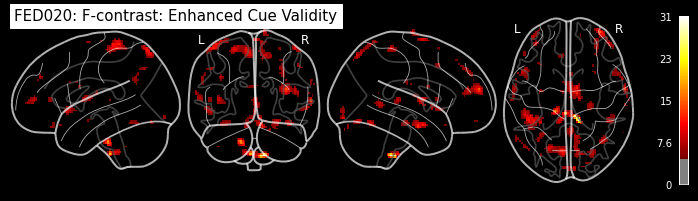

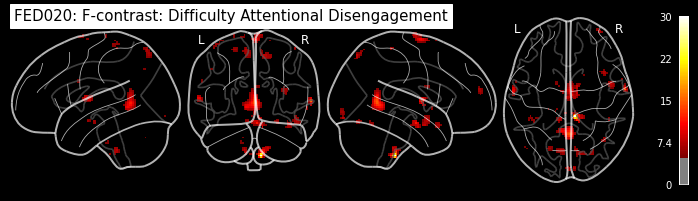

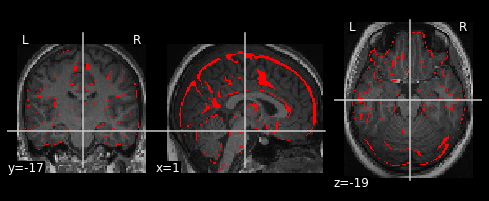

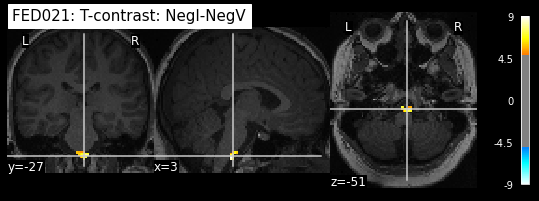

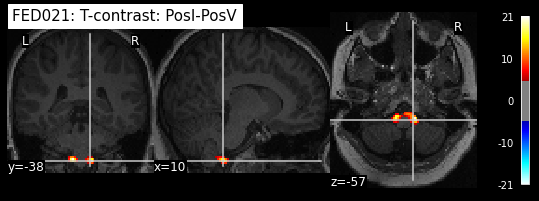

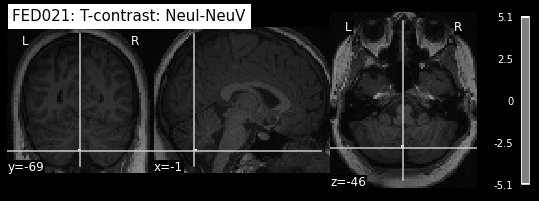

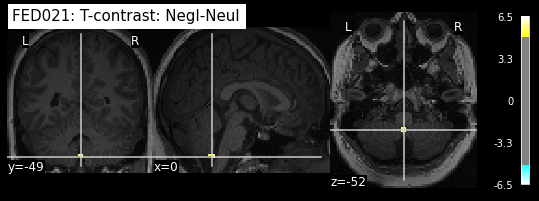

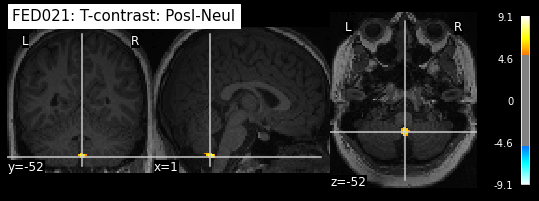

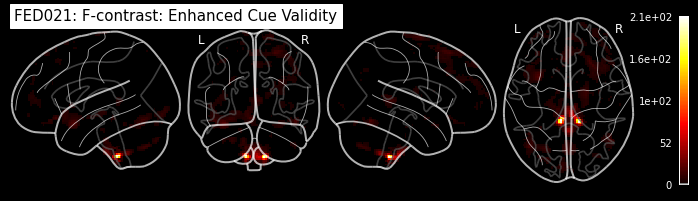

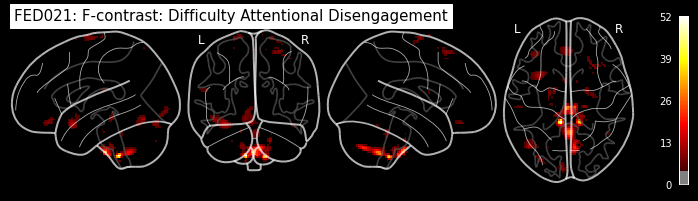

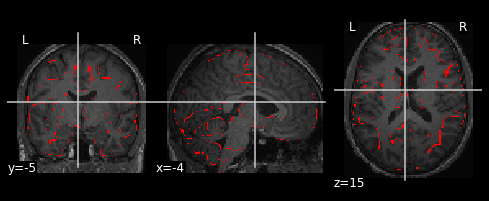

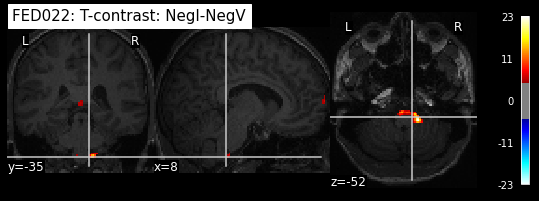

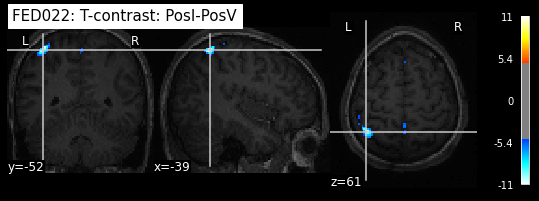

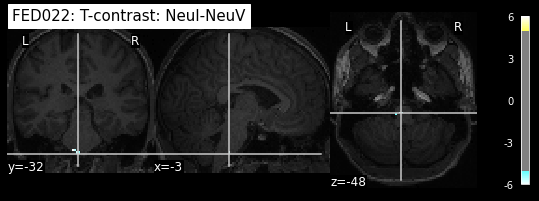

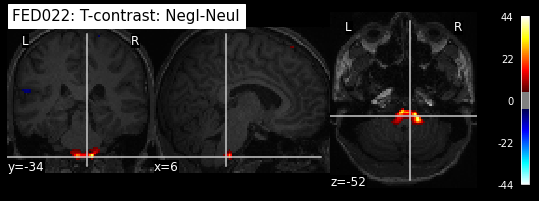

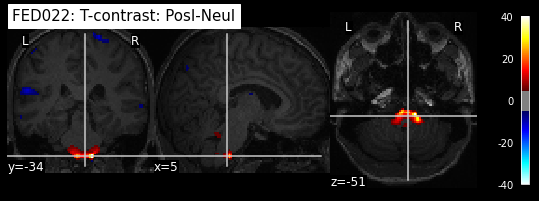

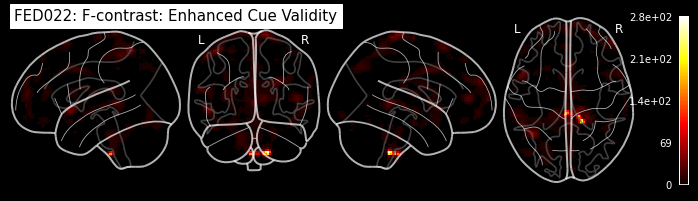

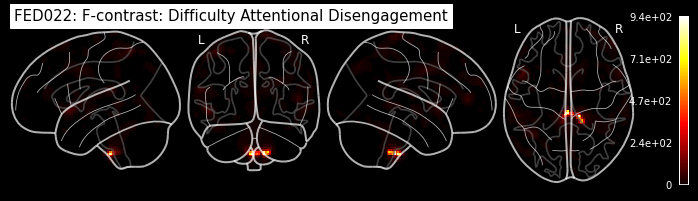

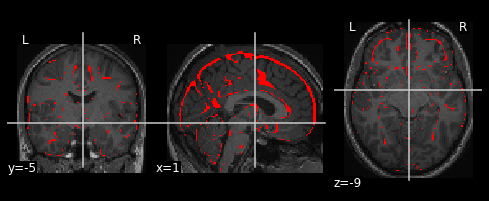

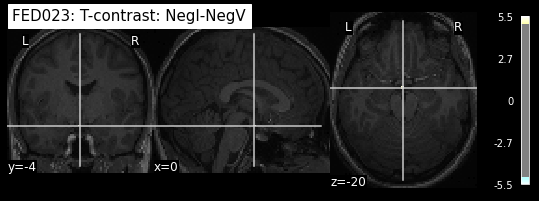

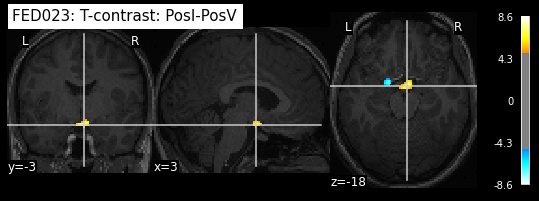

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:141: UserWarning: Could not determine cut coords: All voxels were masked by the thresholding. Returning the center of mass instead.
  "Could not determine cut coords: "
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


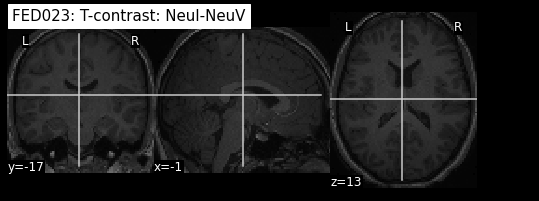

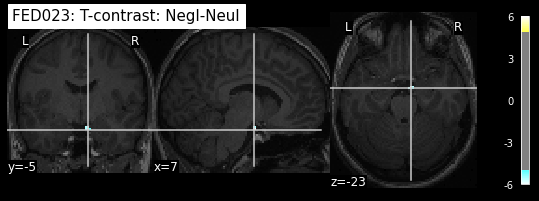

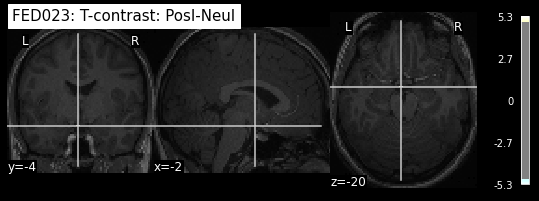

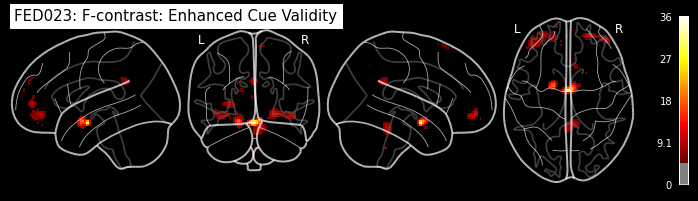

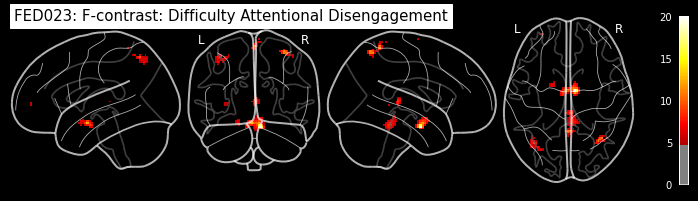

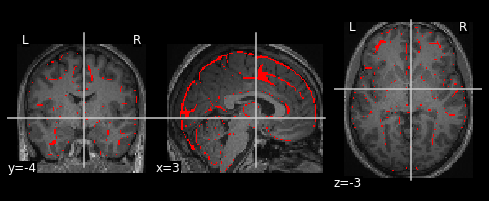

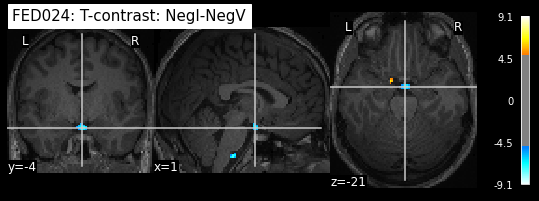

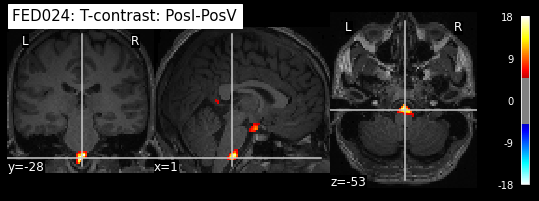

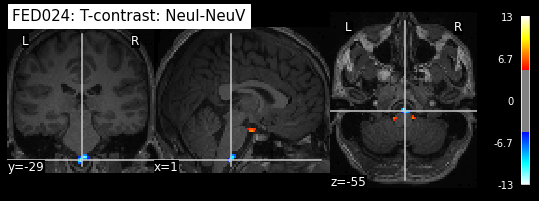

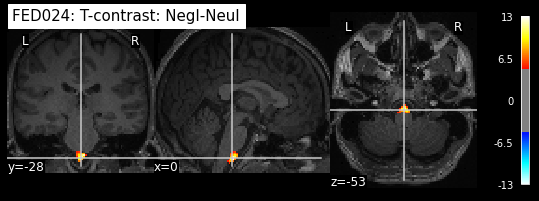

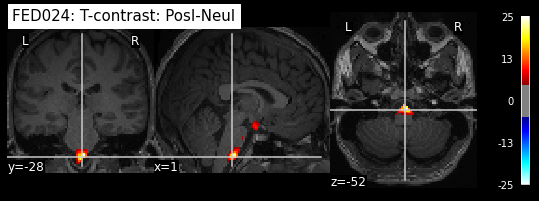

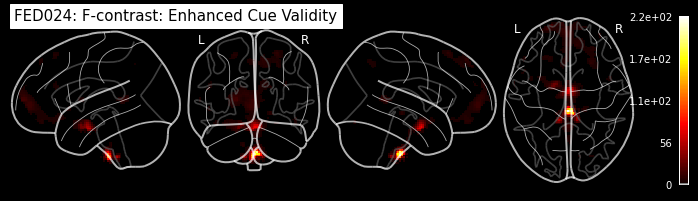

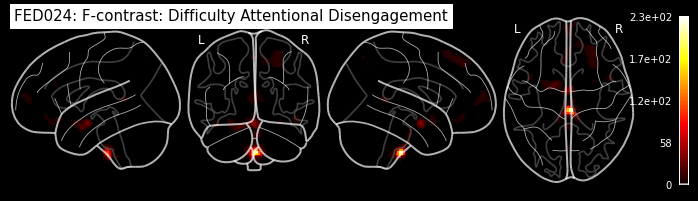

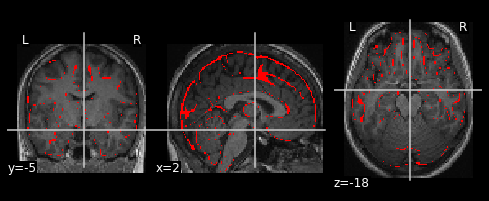

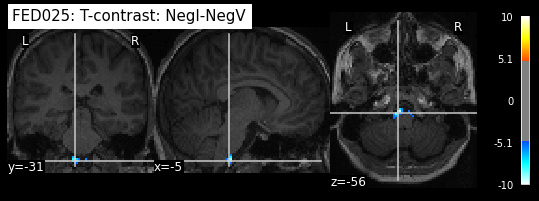

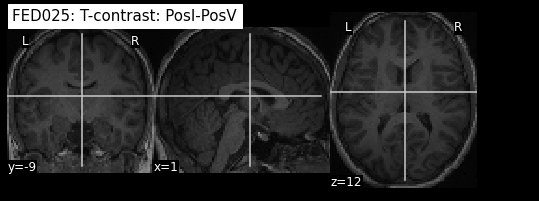

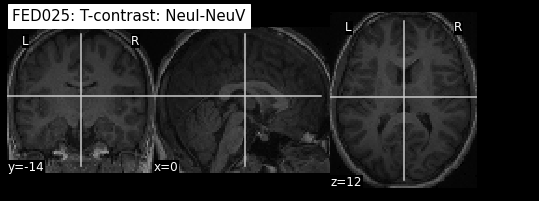

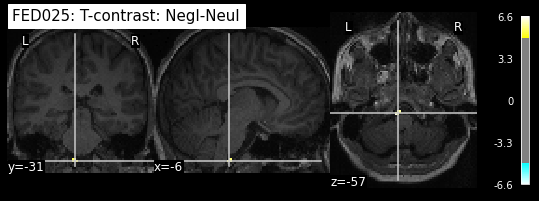

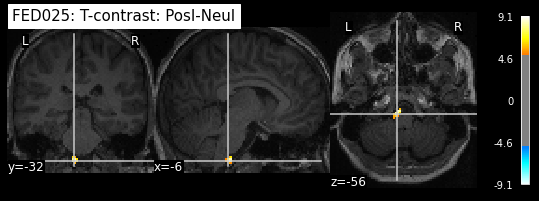

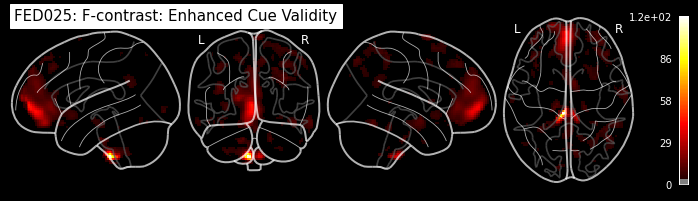

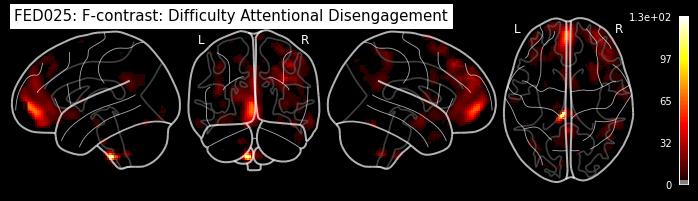

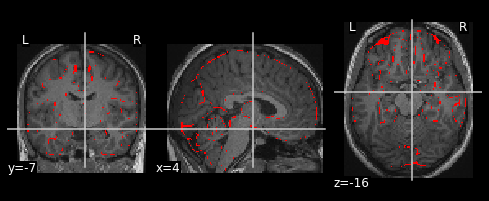

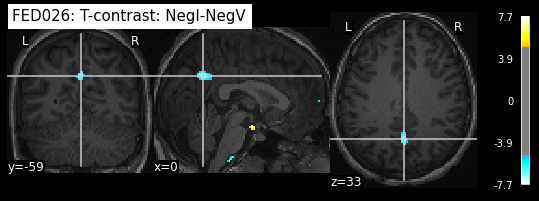

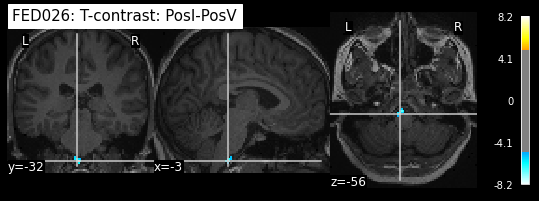

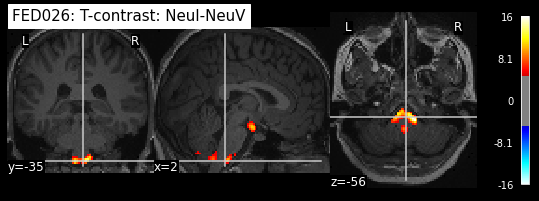

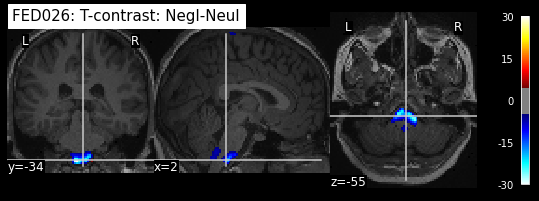

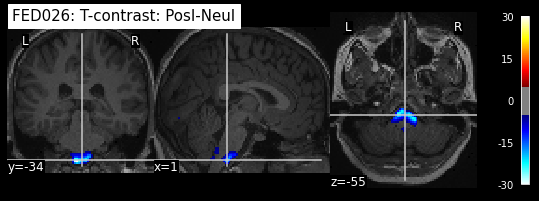

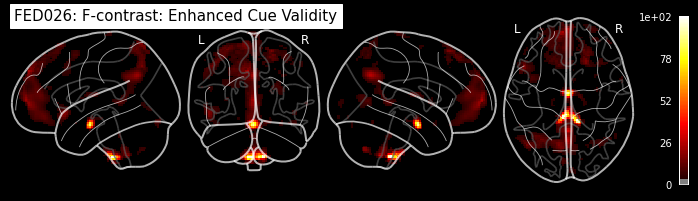

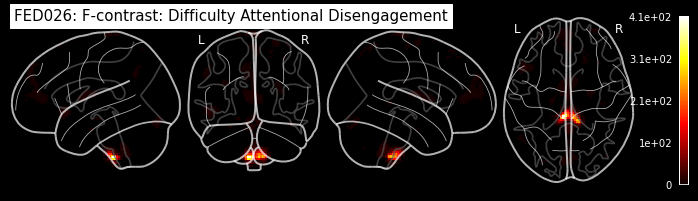

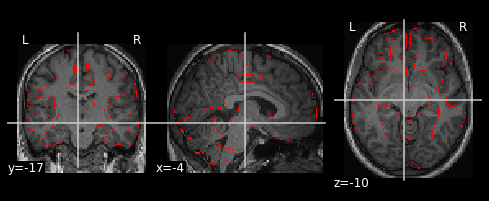

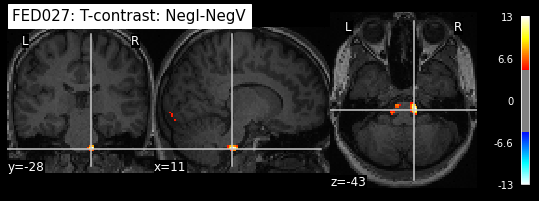

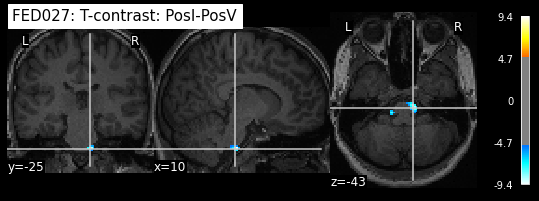

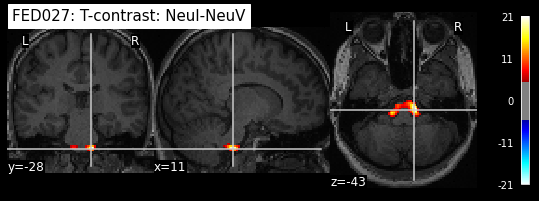

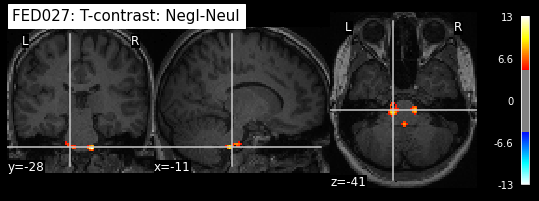

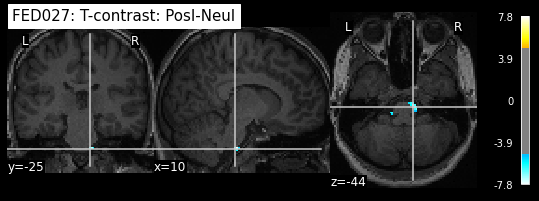

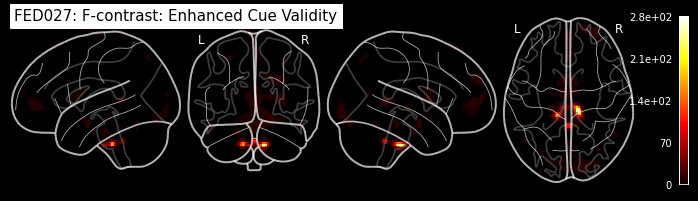

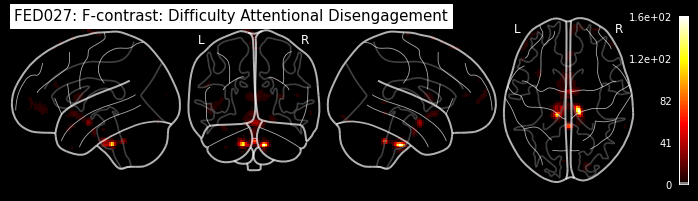

In [10]:
# Load GM probability map of TPM.nii
tpm = nb.load(spm_mnitpm)
GM_template = nb.Nifti1Image(np.asanyarray(tpm.dataobj)[..., 0], tpm.affine, tpm.header)

# Plot anatomical with TPM and contrasts on glass brain to check if normalisation was successful
for subdir in FED_dirs:
    # create model dirs
    SPMwcon_dir = f"{subdir}model_specifications/level1design/mod_estimate/1stlevel_contrast_estimates/normalize/"
    # gather parameter estimates
    con_ests = sorted([f"{SPMwcon_dir}{wcon_file}"
                       for wcon_file in os.listdir(f"{SPMwcon_dir}")
                       if re.match(r'.*(wcon|wess)_[0-9]{4}.nii$', wcon_file)])
    # and the normalised structural
    norm_struct = [f"{SPMwcon_dir}{wcon_file}"
                   for wcon_file in os.listdir(f"{SPMwcon_dir}")
                   if re.match(r'.*wT1_M.*.nii$', wcon_file)][0]

    # Plot normalized subject anatomy
    display = ni_plt.plot_anat(norm_struct, dim = -0.1)
    # Overlay in edges GM map
    display.add_edges(GM_template)

    # Let's look at the contrasts of one subject that we've just computed.
    # The T-contrasts:
    for wcon, title in zip(con_ests[:-2], contrasts_fin[:-2]):
        glassbrainplt = ni_plt.plot_stat_map(wcon, bg_img = norm_struct, colorbar=True, display_mode='ortho', black_bg=True, threshold=5,
                                                title=f"{subdir.rsplit('/', 2)[1]}: T-contrast: {title[0]}");
        # print the figure to the screen
        plt.show(glassbrainplt)
        # close the figure to prevent memory overload
        glassbrainplt.close()
    # The F-contrasts:
    for wcon, title in zip(con_ests[-2:], contrasts_fin[-2:]):
        glassbrainplt = ni_plt.plot_glass_brain(wcon, colorbar=True, display_mode='lyrz', black_bg=True, threshold=5,
                                                title=f"{subdir.rsplit('/', 2)[1]}: F-contrast: {title[0]}");
        # print the figure to the screen
        plt.show(glassbrainplt)
        # close the figure to prevent memory overload
        glassbrainplt.close()

# QC

To do:

1. Reduce printed output in all notebooks to an appropriate amount
2. Look for Jupyterlab /Markdown Latex integration/other options

In [4]:
#a = np.full((3, 3, 3), 2)
#b = np.full((3, 3, 3), 0)
#b[1].fill(2)

#print(f"a:\n{a}\n", f"b:\n{b}\n")

#c = np.add(a, b)

#print(f"c:\n{c}")

In [5]:
# The the maximum value entry to None in oder to tell panda to print all rows and columns
#pd.set_option("display.max_rows", None, "display.max_columns", None)

#print(data["FED007"]["parameters"]["modelparams"])